In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [9]:
img = cv2.imread(r"E:\Jain Irrigation\data\A\train_cropped\IMG_20250920_111112931.jpg")

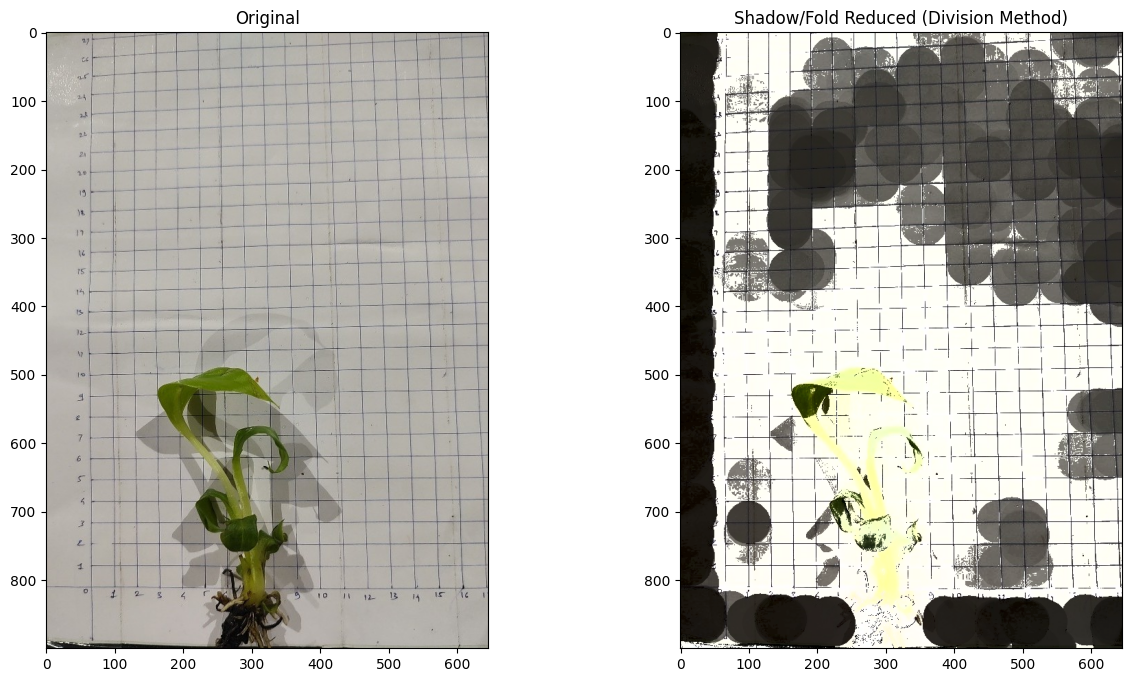

In [8]:
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)

# --- Estimate illumination (very large kernel) ---
illum = cv2.morphologyEx(l, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(61,61)))

# --- Divide by illumination to flatten lighting ---
l_float = l.astype(np.float32)
illum_float = illum.astype(np.float32) + 1  # avoid divide by zero
l_flat = (l_float / illum_float) * 128      # rescale mid-gray
l_flat = np.clip(l_flat,0,255).astype(np.uint8)

# --- Contrast normalization ---
l_norm = cv2.equalizeHist(l_flat)

# --- Merge back and convert ---
merged = cv2.merge((l_norm, a, b))
img_shadowfree = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

# --- Visualization ---
plt.figure(figsize=(15,8))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(img_shadowfree, cv2.COLOR_BGR2RGB)); plt.title("Shadow/Fold Reduced (Division Method)")
plt.show()

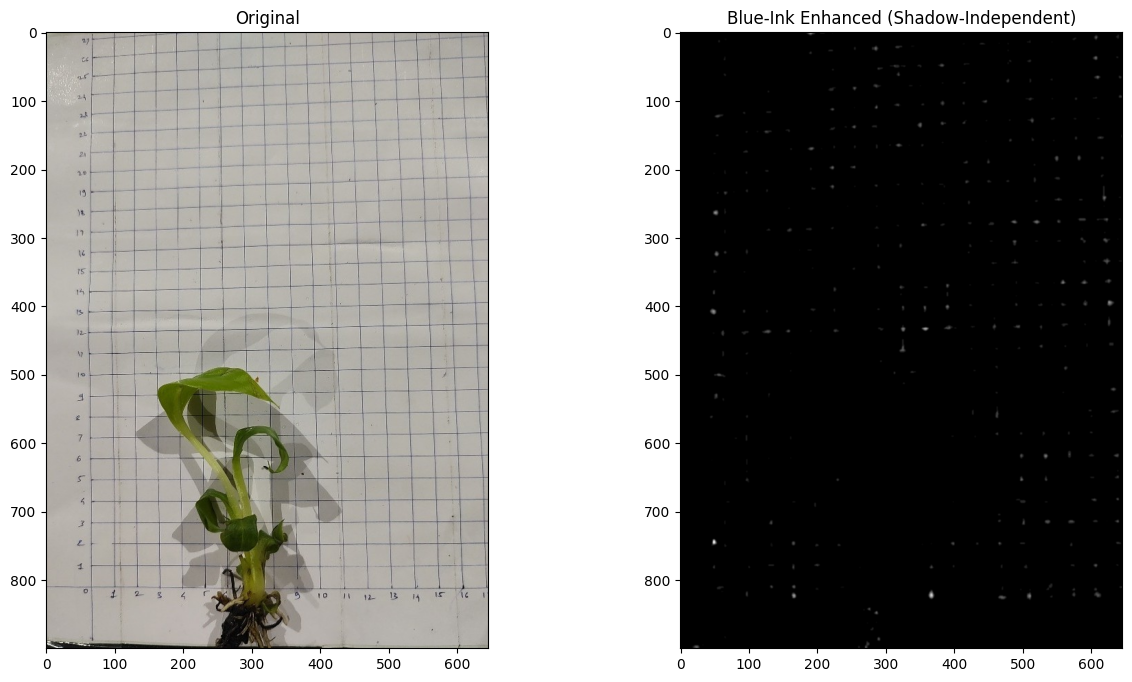

In [10]:
b, g, r = cv2.split(img)
# Ball-pen strokes appear bluish ⇒ emphasize blue vs red/green
ink_enh = cv2.subtract(b, ((r.astype(np.uint16)+g.astype(np.uint16))//2).astype(np.uint8))
ink_enh = cv2.normalize(ink_enh, None, 0, 255, cv2.NORM_MINMAX)

# --- Local contrast enhancement ---
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
ink_clahe = clahe.apply(ink_enh)

# --- Mild denoising ---
ink_blur = cv2.GaussianBlur(ink_clahe, (3,3), 0)

plt.figure(figsize=(15,8))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(ink_blur, cmap='gray'); plt.title("Blue-Ink Enhanced (Shadow-Independent)")
plt.show()

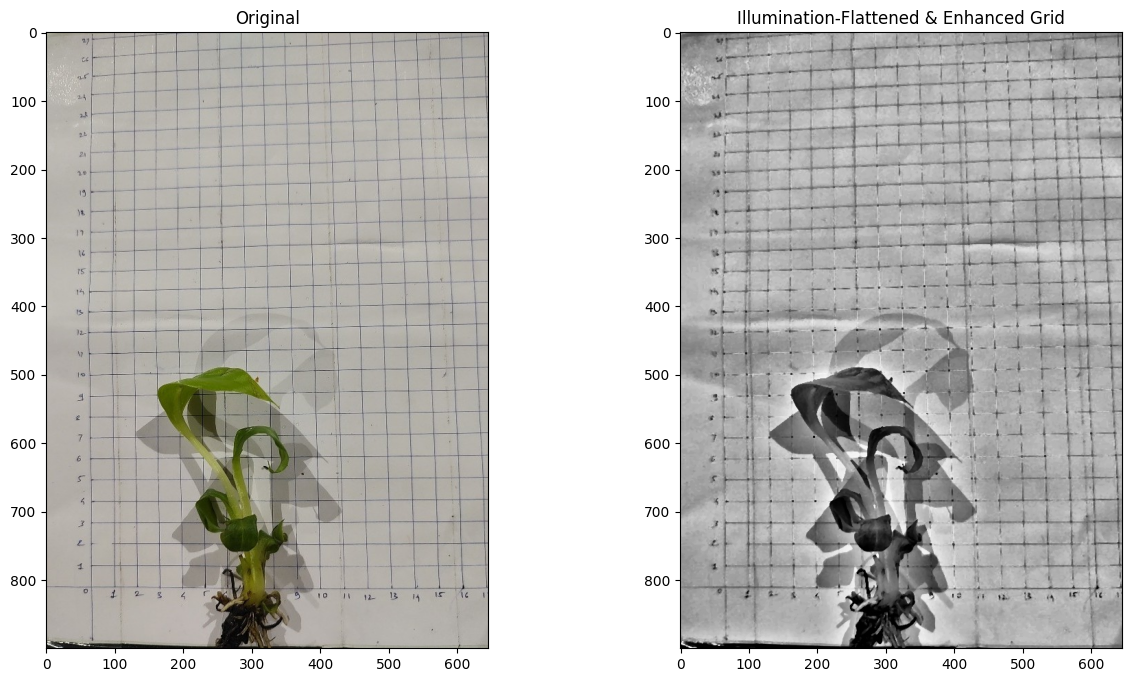

In [11]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# --- 2. Remove slow illumination gradients (works for folds/shadows) ---
blur = cv2.GaussianBlur(gray, (95,95), 0)
illum_corrected = cv2.addWeighted(gray, 1.5, blur, -0.5, 0)

# --- 3. Local contrast enhancement ---
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
enhanced = clahe.apply(cv2.normalize(illum_corrected, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))

# --- 4. Mild denoising ---
enhanced = cv2.medianBlur(enhanced, 3)

plt.figure(figsize=(15,8))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(enhanced, cmap="gray"); plt.title("Illumination-Flattened & Enhanced Grid")
plt.show()

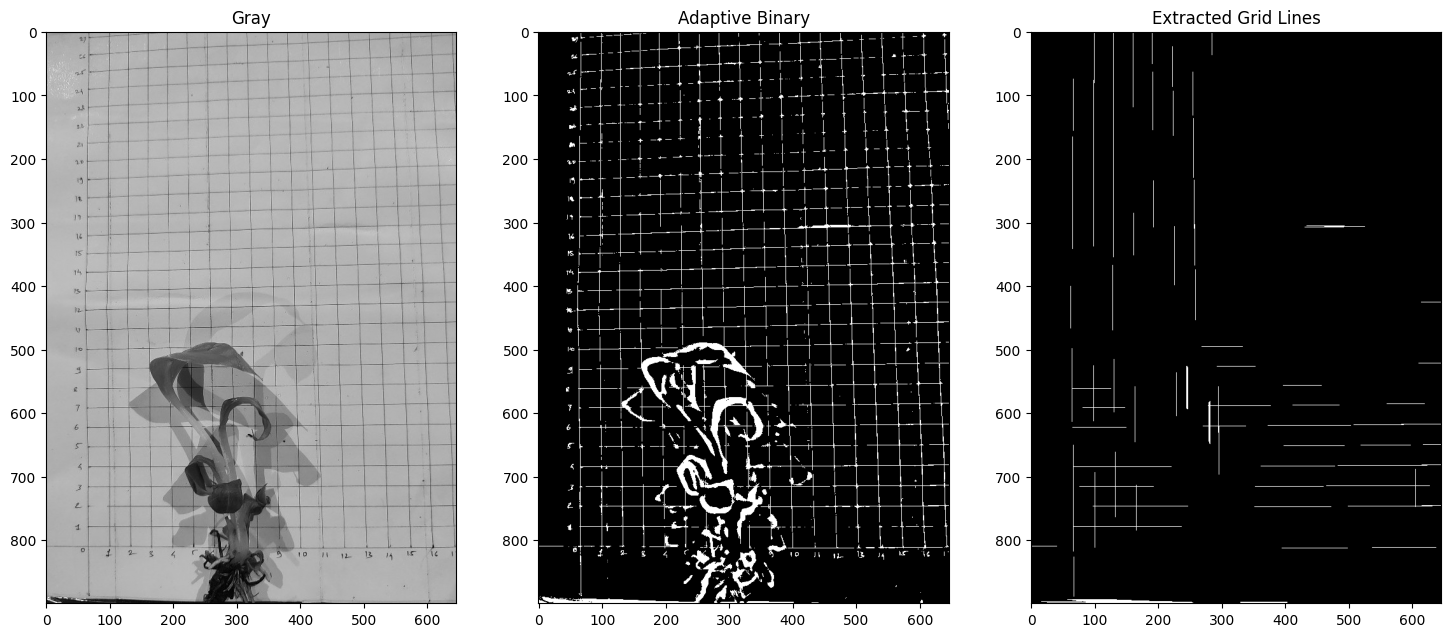

In [12]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# --- 2. Denoise slightly ---
gray_blur = cv2.bilateralFilter(gray, 9, 50, 50)

# --- 3. Adaptive threshold for local contrast ---
thr = cv2.adaptiveThreshold(gray_blur, 255,
                            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv2.THRESH_BINARY_INV,
                            35, 8)

# --- 4. Morphological filters to strengthen long lines ---
kernel_h = cv2.getStructuringElement(cv2.MORPH_RECT, (60,1))
kernel_v = cv2.getStructuringElement(cv2.MORPH_RECT, (1,60))
h_lines = cv2.morphologyEx(thr, cv2.MORPH_OPEN, kernel_h)
v_lines = cv2.morphologyEx(thr, cv2.MORPH_OPEN, kernel_v)
grid_mask = cv2.bitwise_or(h_lines, v_lines)

plt.figure(figsize=(18,8))
plt.subplot(1,3,1); plt.imshow(gray, cmap='gray'); plt.title("Gray")
plt.subplot(1,3,2); plt.imshow(thr, cmap='gray'); plt.title("Adaptive Binary")
plt.subplot(1,3,3); plt.imshow(grid_mask, cmap='gray'); plt.title("Extracted Grid Lines")
plt.show()

In [18]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# --- Enhance text ---
bh = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, np.ones((9,9),np.uint8))
_, text_mask = cv2.threshold(bh, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# --- OCR pass ---
custom_config = r'--oem 3 --psm 6 outputbase digits'
data = pytesseract.image_to_data(text_mask, config=custom_config, output_type=pytesseract.Output.DICT)

coords = []
for i,txt in enumerate(data['text']):
    if txt.strip().isdigit():
        x,y,w,h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
        coords.append((int(txt), x+w//2, y+h//2))

# visualize
vis = img.copy()
for num, x, y in coords:
    cv2.putText(vis, str(num), (x-10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
    cv2.circle(vis, (x,y), 5, (255,0,0), -1)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("Detected handwritten axis digits")
plt.show()

coords.sort(key=lambda c:(c[2],c[1]))  # roughly sorted
print(coords[:10])

NameError: name 'pytesseract' is not defined

In [12]:
from PIL import Image
import torch
from transformers import AutoProcessor, AutoModelForCausalLM

In [14]:
model_id = "microsoft/Florence-2-large"
device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

torch.nn.Module._supports_sdpa = property(lambda self: False)

processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True)

AttributeError: 'Florence2ForConditionalGeneration' object has no attribute '_supports_sdpa'

In [6]:
image = Image.open(r"E:\Jain Irrigation\data\A\train_cropped\IMG_20250920_110830496_HDR.jpg").convert("RGB")

In [15]:
# only the task token here
inputs = processor(text="<OD>", images=image, return_tensors="pt").to(device, torch_dtype)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

result = processor.post_process_generation(
    generated_text,
    task="<OD>",
    image_size=(image.width, image.height)
)

print(result)

NameError: name 'model' is not defined

In [2]:
from PIL import Image
import cv2, torch, numpy as np, json
from transformers import AutoProcessor, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = "microsoft/Florence-2-large"
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).to(device)

image_path = r"E:\Jain Irrigation\data\A\train_cropped\IMG_20250920_110830496_HDR.jpg"
image = Image.open(image_path).convert("RGB")

# Florence detection
inputs = processor(text="<OD>", images=image, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_new_tokens=1024)
text = processor.batch_decode(outputs, skip_special_tokens=False)[0]
result = processor.post_process_generation(text, task="<OD>", image_size=(image.width, image.height))
print(json.dumps(result, indent=2))

# --- Extract boxes & labels properly ---
od = result.get("<OD>", {})
boxes = od.get("bboxes", [])
labels = od.get("labels", [])
objs = list(zip(labels, boxes))

# --- Measure features ---
def box_area(b): return max(0, (b[2]-b[0])) * max(0, (b[3]-b[1]))

leaf_boxes = [b for label,b in objs if "leaf" in label.lower()]
root_boxes = [b for label,b in objs if "root" in label.lower()]
stem_boxes = [b for label,b in objs if "stem" in label.lower()]

# Height = overall vertical span of all detected regions
if boxes:
    y_min = min(b[1] for b in boxes)
    y_max = max(b[3] for b in boxes)
    height_px = y_max - y_min
else:
    height_px = 0

leaf_area = sum(box_area(b) for b in leaf_boxes)
root_area = sum(box_area(b) for b in root_boxes)
ratio = leaf_area / (root_area + 1e-6)

summary = {
    "leaf_count": len(leaf_boxes),
    "plant_height_px": round(height_px, 2),
    "leaf_to_root_ratio": round(ratio, 3)
}
print("\n=== Summary ===")
print(json.dumps(summary, indent=2))

# --- Visualization ---
img = cv2.imread(image_path)
for label,box in objs:
    x1,y1,x2,y2 = map(int, box)
    color = (0,255,0) if "leaf" in label.lower() else (255,0,0) if "root" in label.lower() else (0,0,255)
    cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
    cv2.putText(img, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

cv2.putText(img, f"Height(px): {int(height_px)}", (20,40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,0), 2)
cv2.imwrite("florence_measured.jpg", img)
print("Saved annotated image as florence_measured.jpg")

{
  "<OD>": {
    "bboxes": [
      [
        227.65399169921875,
        444.25048828125,
        453.0539855957031,
        820.9614868164062
      ],
      [
        310.7300109863281,
        732.0274658203125,
        395.7380065917969,
        821.8004760742188
      ]
    ],
    "labels": [
      "houseplant",
      "insect"
    ]
  }
}

=== Summary ===
{
  "leaf_count": 0,
  "plant_height_px": 377.55,
  "leaf_to_root_ratio": 0.0
}
Saved annotated image as florence_measured.jpg


In [17]:
import json, re, cv2

# Parse the JSON from LLaVA output
match = re.search(r"\{.*\}", answer, re.DOTALL)
json_str = re.sub(r",\s*}", "}", match.group(0))
json_str = re.sub(r",\s*]", "]", json_str)
data = json.loads(json_str)

# Load image
image_path = r"E:\Jain Irrigation\data\A\train_cropped\IMG_20250920_110830496_HDR.jpg"
img = cv2.imread(image_path)
h, w = img.shape[:2]

# Function to convert YOLO-style normalized (x_center, y_center, w, h)
def normalized_to_pixels(box, w_img, h_img):
    cx = box["x"] * w_img
    cy = box["y"] * h_img
    bw = box["width"] * w_img
    bh = box["height"] * h_img
    x1 = int(cx - bw / 2)
    y1 = int(cy - bh / 2)
    x2 = int(cx + bw / 2)
    y2 = int(cy + bh / 2)
    return x1, y1, x2, y2

# Convert all leaf boxes
pixel_boxes = []
for b in data.get("leaf_bounding_boxes", []):
    x1, y1, x2, y2 = normalized_to_pixels(b, w, h)
    pixel_boxes.append((x1, y1, x2, y2))
    cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
    cv2.putText(img, "leaf", (x1, max(20, y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

cv2.imwrite("llava_pixel_boxes.jpg", img)
print("Saved annotated image as llava_pixel_boxes.jpg")

# Print coordinates in pixels
for i, (x1, y1, x2, y2) in enumerate(pixel_boxes, 1):
    print(f"Leaf {i}: ({x1}, {y1}) -> ({x2}, {y2})")


Saved annotated image as llava_pixel_boxes.jpg
Leaf 1: (53, 164) -> (429, 884)
Leaf 2: (75, 80) -> (547, 800)
Leaf 3: (139, 191) -> (611, 912)


In [22]:
from transformers import AutoProcessor, AutoModelForVision2Seq
from PIL import Image
import torch, json, re

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "llava-hf/llava-v1.6-mistral-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForVision2Seq.from_pretrained(model_id, torch_dtype=torch.float16, device_map="auto")

# Load image
image_path = r"E:\Jain Irrigation\data\A\train_cropped\IMG_20250920_110830496_HDR.jpg"
image = Image.open(image_path).convert("RGB")
width, height = image.size

# 🔹 Include dimensions in the prompt itself
prompt = f"""
You are an expert banana shoot classifier.

The image provided has exact dimensions: {width} pixels wide and {height} pixels tall.

Analyse this banana shoot image and return valid JSON containing:
- total number of leaves
- estimated plant height in pixels with respect to the numbered grid in the background
- ratio of total leaf area to total root area

Important:
- distinguish properly between the green leafs and the shadows. 
- check the grid and axis markings/labels for getting estimate of the plant height.

Return your answer strictly as valid JSON enclosed by curly braces, without code fences or extra text.
"""

# Insert <image> token
prompt_with_token = f"<image>\n{prompt}"

# Process and run
inputs = processor(text=prompt_with_token, images=image, return_tensors="pt").to(device)
out = model.generate(**inputs, max_new_tokens=1024)
answer = processor.decode(out[0], skip_special_tokens=True)

print("\nRaw model output:\n", answer)


Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00, 53.56it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Raw model output:
 

You are an expert banana shoot classifier.

The image provided has exact dimensions: 644 pixels wide and 839 pixels tall.

Analyse this banana shoot image and return valid JSON containing:
- total number of leaves
- estimated plant height in pixels with respect to the numbered grid in the background
- ratio of total leaf area to total root area

Important:
- distinguish properly between the green leafs and the shadows. 
- check the grid and axis markings/labels for getting estimate of the plant height.

Return your answer strictly as valid JSON enclosed by curly braces, without code fences or extra text.

{
"total_number_of_leaves": 10,
"estimated_plant_height_in_pixels": 120,
"ratio_of_total_leaf_area_to_total_root_area": 0.5
} 


In [1]:
from transformers import AutoProcessor, AutoModelForVision2Seq
from PIL import Image
import torch, json, re

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-72B-Instruct")
AutoModelForVision2Seq.from_pretrained("Qwen/Qwen2.5-VL-72B-Instruct")

image = Image.open(r"E:\Jain Irrigation\data\A\train_cropped\IMG_20250920_110830496_HDR.jpg")

prompt = """
You are an expert botanist.
Analyse this image and output valid JSON with:
- pixel bounding boxes (x1,y1,x2,y2) for each leaf, stem, root
- total leaf count
- plant height in pixels
- leaf-to-root area ratio
Return JSON only, no code fences.
"""

inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
out = model.generate(**inputs, max_new_tokens=1024)
answer = processor.decode(out[0], skip_special_tokens=True)

# optional JSON cleaning
match = re.search(r"\{.*\}", answer, re.DOTALL)
if match:
    data = json.loads(match.group(0))
    print(json.dumps(data, indent=2))
else:
    print(answer)

e:\Jain Irrigation\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
e:\Jain Irrigation\venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--Qwen--Qwen2.5-VL-72B-Instruct. Caching files will still work but in a degraded version t

: 

In [5]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch, json

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "microsoft/Florence-2-large"

processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).to(device)

image = Image.open(r"E:\Jain Irrigation\data\A\train_cropped\IMG_20250920_110830496_HDR.jpg").convert("RGB")

# 🟢 use <REF> + your own text
inputs = processor(
    text="<REF> leaf, number of leafs, and root",
    images=image,
    return_tensors="pt"
).to(device)

outputs = model.generate(**inputs, max_new_tokens=1024)
text = processor.batch_decode(outputs, skip_special_tokens=False)[0]

result = processor.post_process_generation(
    text,
    task="<REF>",
    image_size=(image.width, image.height)
)

print(json.dumps(result, indent=2))

{
  "<REF>": "> leaf, number of leafs, and root> plant with root<loc_352><loc_529><loc_702><loc_978>"
}
